<sup>This notebook is adapted from code from *Deep Learning with Python 2nd edition* by Francois Challot. 

<sup>See the original code in the books' companion [GitHub](https://github.com/fchollet/deep-learning-with-python-notebooks).  Find the book here: [Amazon Link](https://www.amazon.com/Learning-Python-Second-Fran-C3-A7ois-Chollet-dp-1617296864/dp/1617296864/)



## Classifying movie reviews: A binary classification example

IMDB data set: 50K positive or negative reviews

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### Loading the IMDB dataset

Already split into 25K train, 25K test. Each review is a list of integers, where the integer is an index into dictionary.

The parameter num_words limits the vocabulary to the 10K most frequent words.

Labels are 0 for negative and 1 for positive.

In [2]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
train_labels[0]

1

In [5]:
max([max(sequence) for sequence in train_data])

9999

### Decoding reviews back to text

Reconstruct a review by looking up the index numbers in the word index.

The indices are offset by 3 because indices 0, 1, and 2 are reserved for padding, start of sequence, and unknown.

In [6]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

1654784/1641221 [==============================] - 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data

There are two ways to turn these lists of integers into ML-ready data.

1. Pad the lists so they are all the same length. Use an embedding layer to turn the integers into real-numbered values. We'll do that later.
2. Turn the integer list into a multi-hot list that is 10K long. Each element would be 0 or 1, if that word is not, or is, in the review. A Dense layer could handle this as input.

### Encoding the integer sequences via multi-hot encoding

The following code creates the vectors.

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Next, vectorize the labels.

In [9]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

## Model definition

Two hidden layers with 16 units each, with relu activation. The weight matrix W for each will have shape (n, 15), where n is the number of input observations.

A final output layer with sigmoid activation for the classification.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

### Compiling the model

Use the basic rmsprop algorithm, and binary crossentropy for this binary classification problem. Accuracy is a good metric for training.

In [11]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Setting aside a validation set

Take 10K observations from training data to be the validation data.

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### Train the model

Train for 20 epochs, in batches of size 512.

Store the training history in a variable, 'history', so it can be plotted later.

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 26ms/step - loss: 0.5121 - accuracy: 0.7740 - val_loss: 0.3791 - val_accuracy: 0.8692
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2968 - accuracy: 0.9047 - val_loss: 0.2999 - val_accuracy: 0.8884
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2187 - accuracy: 0.9294 - val_loss: 0.3239 - val_accuracy: 0.8681
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1732 - accuracy: 0.9445 - val_loss: 0.2875 - val_accuracy: 0.8859
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1426 - accuracy: 0.9565 - val_loss: 0.2801 - val_accuracy: 0.8885
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1171 - accuracy: 0.9646 - val_loss: 0.2954 - val_accuracy: 0.8842
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0980 - accuracy: 0.9702 - val_loss: 0.3070 - val_accuracy: 0.8838
Epoch 8/20
30

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plotting the training and validation loss

The training loss continues to go down across the epochs, while the validation loss initially dips, then rises. This shows overfitting.

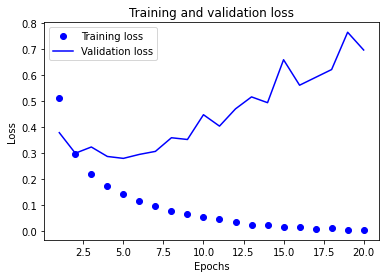

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plotting the training and validation accuracy

Again, we see evidence of overfitting because the training accuracy continues to climb while the validation accuracy starts to decline.

After about the 4th epoch, the model overfits to the training data, so it won't generalize well to unseen test data.

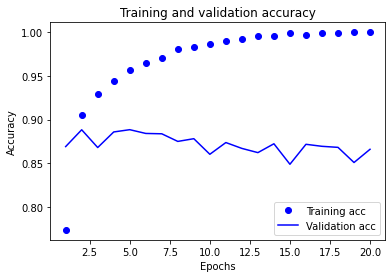

In [16]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Retraining a model

Use only 4 epochs to avoid overfitting.

In [17]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.4457 - accuracy: 0.8134
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2547 - accuracy: 0.9096
Epoch 3/4
49/49 [==============================] - 1s 15ms/step - loss: 0.1973 - accuracy: 0.9288
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.3009 - accuracy: 0.8818


### Test set evaluation

This simple model, training only 4 epochs, reached 88% accuracy. Not bad.

In [18]:
results

[0.3008579611778259, 0.8817999958992004]

### Using a trained model to generate predictions on new data

Notice that the predict function output probability of the positive class.

In [19]:
model.predict(x_test)

array([[0.18804848],
       [0.99976623],
       [0.75930464],
       ...,
       [0.11005715],
       [0.05418533],
       [0.5636111 ]], dtype=float32)

### More things to try

To try to improve the results, we could:

* use different numbers of layers (more or less)
* use more or fewer units
* use mse loss instead of binary crossentropy
* use tanh activation